In [95]:
# -*- coding: utf-8 -*-
"""
Spyder Editor

This is a temporary script file.
"""

import json
import matplotlib.pyplot as plt
import numpy as np
import pystan
import random

In [96]:
baseline="""

data {
      int<lower=1> I; // number of products
      int<lower=1> N; // number of reviews
      int<lower=1> J; // number of reviewers
      vector<lower=0> [N] scores; // review scores vector
      int reviewerID[N]; // reviewer ID for each review
      int prodID[N]; // product ID for each review
}

parameters {
    vector [I] truescore;
    vector [J] reviewbias;
    real<lower=0> c;
    real<lower=0> d;
}

model {
    c ~ gamma(1,1);
    truescore ~ normal(3,1); // TODO: change hyperparameters for data 
    reviewbias ~ normal(0, 1/c);
    for (i in 1:N) {
        scores[i] ~ normal(truescore[prodID[i]] + reviewbias[reviewerID[i]], 1);
        } 
    }

"""

In [99]:
model1="""
data {
    int<lower=1> I; // number of products
    int<lower=1> N; // number of reviews
    int<lower=1> J; // number of reviewers
    vector<lower=0> [N] scores; // review scores vector 
    int reviewerID[N]; // reviewer ID for each review
    int prodID[N]; // product ID for each review
}
parameters {
    vector [I] truescore;
    vector [J] reviewbias;
    real<lower=0> c;
    real<lower=0> d;
}
model {
    c ~ gamma(1,1);
    d ~ gamma(1,1);
    truescore ~ normal(3,1); // TODO: change hyperparameters for data 
    reviewbias ~ normal(0, 1/c);
    for (i in 1:N) {
       scores[i] ~ normal(truescore[prodID[i]]+ reviewbias[reviewerID[i]], 1/d);
    }
}

"""

In [100]:
path='reviews_Amazon_Instant_Video_5.json'

data=[]
for line in open(path,'r'):
    data.append(json.loads(line))

products={}
for d in data:
    if d['asin'] not in products:
        
        products[d['asin']] = [d]
    
    else:
        
        products[d['asin']].append(d)
        
users={}
for d in data:
    
    if d['reviewerID'] not in users:
        
        users[d['reviewerID']] = [d]
    
    else:
        
        users[d['reviewerID']].append(d)

print('No of reviews',len(data))   
print('No of reviewers',len(users))  
print('No. of products reviewed',len(products.keys()))

count1=0
rusers={}
for key in users.keys():
    
    if len(users[key])>10:
        pr=[]
        diff=0
        for i in users[key]:
            if i['asin'] not in pr:
                pr.append(i['asin'])
            else:
                diff+=1
        if(len(users[key])-diff>10):
            count1+=1
            rusers[key]=users[key]
                
print('No of users with more than 10 reviews',count1)

count2=0
rproducts={}
for key in products.keys():
    
    if len(products[key])>10:
        ur=[]
        diff=0
        for i in products[key]:
            if i['reviewerID'] not in ur:
                ur.append(i['reviewerID'])
            else:
                diff+=1
        if(len(products[key])-diff>10):
            count2+=1
            rproducts[key]=products[key]


print('No of products with more than 10 reviews',count2)

print("Reduced users",len(rusers))
print("Reduced products",len(rproducts))



rmap={}
pmap={}
rcount=1
pcount=1

for key in rusers.keys():
    rmap[key]=rcount
    rcount+=1

for key in rproducts.keys():
    pmap[key]=pcount
    pcount+=1


reviewer=[]
product=[]
ratings=[]
helpful=[]

for key in rusers.keys():
    for prod in rusers[key]:
        
        if prod['asin'] in rproducts:
            reviewer.append(rmap[key])
            product.append(pmap[prod['asin']])
            ratings.append(prod['overall'])
            helpful.append(prod['helpful'])
            
d=[reviewer,product,ratings,helpful]
ind=[]
for i in range(len(d[0])):
    ind.append(i)
random.shuffle(ind)

sdata=[[],[],[],[]]
for i in ind:
    sdata[0].append(d[0][i])
    sdata[1].append(d[1][i])
    sdata[2].append(d[2][i])
    sdata[3].append(d[3][i])

prod=set()
for p in sdata[1]:
    prod.add(p)
print(len(prod))
training_data=[sdata[0][:5000],sdata[1][:5000],sdata[2][:5000],sdata[3][:5000]]
test_data=[sdata[0][5000:],sdata[1][5000:],sdata[2][5000:],sdata[3][5000:]]
train_users=set()
for t in training_data[0]:
    train_users.add(t)
print(len(train_users))

train_products=set()
for p in training_data[1]:
    train_products.add(p)
print(len(train_products))

No of reviews 37126
No of reviewers 5130
No. of products reviewed 1685
No of users with more than 10 reviews 511
No of products with more than 10 reviews 810
Reduced users 511
Reduced products 810
793
511
773


[0, 1]
{'reviewerID': 'A11N155CW1UV02', 'asin': 'B000H00VBQ', 'reviewerName': 'AdrianaM', 'helpful': [0, 0], 'reviewText': "I had big expectations because I love English TV, in particular Investigative and detective stuff but this guy is really boring. It didn't appeal to me at all.", 'overall': 2.0, 'summary': 'A little bit boring for me', 'unixReviewTime': 1399075200, 'reviewTime': '05 3, 2014'}


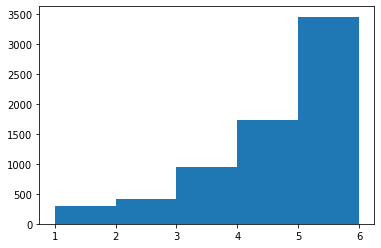

In [101]:
plt.hist(ratings, bins = [1,2,3,4,5,6])

print(helpful[0])

print(data[0])

In [102]:
#Baseline

base_data = {'I': 810, 'N': 5000, 'J':511, 'scores':training_data[2], 'reviewerID':training_data[0], 'prodID':training_data[1]}

sm = pystan.StanModel(model_code=baseline)

fit = sm.sampling(data=base_data, iter=1000, chains=4)

print(fit)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4dae8cd52da8500c9e3b044aad89f788 NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Inference for Stan model: anon_model_4dae8cd52da8500c9e3b044aad89f788.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

                  mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
truescore[1]      3.82    0.13   0.48   2.87   3.47    3.8   4.21   4.58     13   1.37
truescore[2]      4.14    0.07   0.31   3.43   3.93   4.15   4.36   4.72     18   1.24
truescore[3]      3.83     0.2   0.45   2.96   3.47   3.83   4.13   4.65      5    1.5
truescore[4]      3.47    0.51   0.79   2.38   2.69   3.52    4.1   5.11      2   3.41
truescore[5]      3.83     0.1    0.3   3.27   3.59   3.85   4.08   4.31      9   1.38
truescore[6]      3.48    0.13   0.33   2.81   3.29   3.47   3.72   4.09      6   1.55
truescore[7]      3.63    0.17   0.43    2.6   3.38   3.73   3.95   4.26      6    1.7
truescore[8]      3.32    0.42   0.88   1.99   2.59   3.23   3.95   4.94      4   1.52
truescore[9]      4.26    0.11

In [103]:
la = fit.extract(permuted=False)
print(np.shape(la))

(500, 4, 1324)


In [105]:
#Average goodness and bias
goodness=[]
bias=[]
gp=0
bu=0
for k in range(len(rproducts)):
    a=0
    for i in range(np.shape(la)[0]):
        for j in range(np.shape(la)[1]):
            a+=la[i][j][k]
    goodness.append(a/2000)
    gp+=(a/2000)
for p in range(k+1,k+1+len(rusers)):
    a=0
    for i in range(np.shape(la)[0]):
        for j in range(np.shape(la)[1]):
            a+=la[i][j][p]
    bias.append(a/2000)
    bu+=(a/2000)
print(gp/len(rproducts))
print(bu/511)

3.502775648799794
0.41932370306872163


In [106]:
#Training RMSE for Baseline
s=0
for r in range(len(training_data[0])):
    rindex=training_data[0][r]-1
    pindex=training_data[1][r]-1
    a=(training_data[2][r]-goodness[pindex]-bias[rindex])**2
    s+=a
s=(s/5000)**(0.5)
print("Training RMSE for Baseline",s)

0.78964550920829


In [107]:
#Testing RMSE for Baseline
s=0
for r in range(len(test_data[0])):
    rindex=test_data[0][r]-1
    pindex=test_data[1][r]-1
    a=(test_data[2][r]-goodness[pindex]-bias[rindex])**2
    s+=a
s=(s/len(test_data[0]))**(0.5)
print("Testing RMSE for Baseline",s)

1.0263321830035375


In [108]:
#Model 1
base_data = {'I': 810, 'N': 5000, 'J':511, 'scores':training_data[2], 'reviewerID':training_data[0], 'prodID':training_data[1]}

sm = pystan.StanModel(model_code=model1)

fit = sm.sampling(data=base_data, iter=1000, chains=4)

print(fit)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_43b4b4d7b8c6d300dbe8725b4fa103b0 NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Inference for Stan model: anon_model_43b4b4d7b8c6d300dbe8725b4fa103b0.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

                  mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
truescore[1]      3.96    0.01   0.42   3.12   3.67   3.96   4.24   4.77   1556    1.0
truescore[2]      4.23  7.3e-3    0.3   3.64   4.04   4.23   4.43   4.82   1637    1.0
truescore[3]      3.91    0.01   0.43   3.06   3.63   3.92   4.21   4.72   1426    1.0
truescore[4]      4.06    0.01   0.52   3.07    3.7   4.06   4.43   5.06   1691    1.0
truescore[5]      3.85  7.8e-3   0.34    3.2   3.63   3.85   4.08   4.53   1898    1.0
truescore[6]       3.6  8.4e-3   0.35   2.91   3.37   3.61   3.84   4.26   1756    1.0
truescore[7]      3.59    0.01   0.59   2.41   3.19   3.58   3.99   4.73   2120    1.0
truescore[8]      2.76    0.01   0.68   1.44    2.3   2.75   3.21   4.06   2279    1.0
truescore[9]      3.93  9.5e-3

In [109]:
#Average goodness and bias
la = fit.extract(permuted=False)
print(np.shape(la))
goodness=[]
bias=[]
gp=0
bu=0
for k in range(len(rproducts)):
    a=0
    for i in range(np.shape(la)[0]):
        for j in range(np.shape(la)[1]):
            a+=la[i][j][k]
    goodness.append(a/2000)
    gp+=(a/2000)
for p in range(k+1,k+1+len(rusers)):
    a=0
    for i in range(np.shape(la)[0]):
        for j in range(np.shape(la)[1]):
            a+=la[i][j][p]
    bias.append(a/2000)
    bu+=(a/2000)
print(gp/len(rproducts))
print(bu/511)

(500, 4, 1324)
3.50582353166844
0.4451733889845161


In [110]:
#Training RMSE for Model 1
s=0
for r in range(len(training_data[0])):
    rindex=training_data[0][r]-1
    pindex=training_data[1][r]-1
    a=(training_data[2][r]-goodness[pindex]-bias[rindex])**2
    s+=a
s=(s/5000)**(0.5)
print("Training RMSE for Model 1",s)
s=0

#Testing RMSE for Model 1
for r in range(len(test_data[0])):
    rindex=test_data[0][r]-1
    pindex=test_data[1][r]-1
    a=(test_data[2][r]-goodness[pindex]-bias[rindex])**2
    s+=a
s=(s/len(test_data[0]))**(0.5)
print("Testing RMSE for Model 1",s)

0.7676313684608339
0.9993723419048693
